# Trend Following Trading System - Quick Start

This notebook demonstrates the trend-following trading system based on Tom Basso's principles.

**Strategy Overview:**
- Trade 30 sector ETFs long and short
- Keltner Channel breakout entries
- ATR-based position sizing (2% volatility target)
- VaR-based risk management (95% confidence, 20% max)
- Trailing stops activated after 1×ATR profit

## 1. Setup & Configuration

In [1]:
# Standard imports
import sys
from pathlib import Path
from datetime import date, timedelta

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Project imports
from src.utils.config import load_config
from src.data.database import Database
from src.data.fetcher import DataFetcher
from src.backtest.engine import BacktestEngine
from src.reporting.console import print_metrics, print_trade_summary
from src.reporting.charts import create_backtest_report, plot_equity_curve, plot_drawdown

import matplotlib.pyplot as plt
%matplotlib inline

print("Imports successful!")

Imports successful!


In [2]:
# Load configuration
config = load_config(project_root / "config.yaml")

print(f"Starting Capital: ${config.portfolio.starting_capital:,}")
print(f"ETF Universe: {len(config.data.etf_symbols)} symbols")
print(f"Keltner Period: {config.strategy.keltner.ema_period}")
print(f"ATR Multiplier: {config.strategy.keltner.atr_multiplier}")
print(f"Max VaR: {config.risk_management.var.max_var_pct}%")

Starting Capital: $100,000
ETF Universe: 30 symbols
Keltner Period: 20
ATR Multiplier: 1.5
Max VaR: 20.0%


## 2. Fetch Historical Data

In [3]:
# Initialize database and fetcher
db_path = project_root / config.data.database_path
db_path.parent.mkdir(parents=True, exist_ok=True)

db = Database(str(db_path))
fetcher = DataFetcher(db)

print(f"Database: {db_path}")

Database: /Users/bradycooke/trend-follower/data/market_data.db


In [4]:
# Fetch data for all ETFs (this may take a few minutes on first run)
symbols = config.data.etf_symbols + [config.data.benchmark_symbol]

# Calculate start date (5 years ago)
start_date = date.today() - timedelta(days=5*365)

print(f"Fetching data for {len(symbols)} symbols from {start_date}...")
results = fetcher.fetch_multiple(symbols, start_date=start_date)

success = sum(1 for r in results.values() if r > 0)
print(f"Successfully updated {success}/{len(symbols)} symbols")

Fetching data for 31 symbols from 2021-01-03...
Successfully updated 31/31 symbols


In [5]:
# Load data from database
data = {}
for symbol in config.data.etf_symbols:
    df = db.get_price_data(symbol)
    if df is not None and len(df) > 100:
        data[symbol] = df

# Load benchmark
benchmark_data = db.get_price_data(config.data.benchmark_symbol)

print(f"Loaded {len(data)} symbols with sufficient history")
if data:
    sample = list(data.values())[0]
    print(f"Date range: {sample.index[0].date()} to {sample.index[-1].date()}")

Loaded 30 symbols with sufficient history
Date range: 2021-01-04 to 2026-01-02


## 3. Run Backtest

In [6]:
# Initialize backtest engine
engine = BacktestEngine(config)

print("Backtest Engine Configuration:")
print(f"  - Keltner EMA: {config.strategy.keltner.ema_period}")
print(f"  - ATR Period: {config.strategy.keltner.atr_period}")
print(f"  - ATR Multiplier: {config.strategy.keltner.atr_multiplier}")
print(f"  - Initial Stop ATR: {config.strategy.stops.initial_atr_multiple}")
print(f"  - Trailing Stop ATR: {config.strategy.stops.trailing_atr_multiple}")

Backtest Engine Configuration:
  - Keltner EMA: 20
  - ATR Period: 20
  - ATR Multiplier: 1.5
  - Initial Stop ATR: 3.0
  - Trailing Stop ATR: 3.0


In [7]:
# Run backtest
result = engine.run(
    data=data,
    start_date=date(2020, 1, 1),  # Adjust as needed
    end_date=None,  # Run to latest date
    benchmark_data=benchmark_data,
)

print(f"Backtest complete!")
print(f"Total trades: {len(result.trades)}")

Backtest complete!
Total trades: 453


## 4. Performance Results

In [8]:
# Print performance metrics
print_metrics(result.metrics)

PERFORMANCE SUMMARY
Period: 2021-01-04 to 2026-01-02
Trading Days: 1,256

RETURNS
------------------------------
Total Return:      108.62%
CAGR:              15.86%

RISK
------------------------------
Max Drawdown:      25.32%
Volatility (Ann.): 18.51%
Downside Dev.:     18.65%
VaR (95%):         1.51%

RISK-ADJUSTED RETURNS
------------------------------
Sharpe Ratio:      0.89
Sortino Ratio:     0.89
Calmar Ratio:      0.63

TRADE STATISTICS
------------------------------
Total Trades:      453
Winning Trades:    185
Losing Trades:     268
Win Rate:          40.84%
Avg Win:           $897.10
Avg Loss:          $-713.90
Profit Factor:     0.87
Avg Trade Duration:30.0 days
Longest Win Streak:9
Longest Lose Streak:11

BENCHMARK COMPARISON
------------------------------
Alpha (Ann.):      18.31%
Beta:              -0.13
Correlation:       -0.12



In [9]:
# Print trade summary (first 20 trades)
print_trade_summary(result.trades, max_trades=20)

TRADE HISTORY
   # | Symbol | Side  | Entry Date | Exit Date  | Shares |    Entry |     Exit |          P&L |    P&L % | Reason  
------------------------------------------------------------------------------------------------------------------------
   1 | XES    | LONG  | 2021-01-05 | 2021-01-21 |    306 |    48.98 |    49.67 |      $211.53 |    1.41% | stop    
   2 | XLE    | LONG  | 2021-01-06 | 2021-01-22 |    473 |    20.43 |    20.57 |       $63.98 |    0.66% | stop    
   3 | GNR    | LONG  | 2021-01-06 | 2021-01-25 |    312 |    48.25 |    46.87 |     $-431.23 |   -2.86% | stop    
   4 | KRE    | LONG  | 2021-01-06 | 2021-01-27 |    267 |    56.49 |    54.76 |     $-461.92 |   -3.06% | stop    
   5 | XOP    | LONG  | 2021-01-06 | 2021-01-27 |    231 |    65.26 |    64.58 |     $-157.08 |   -1.04% | stop    
   6 | KBE    | LONG  | 2021-01-06 | 2021-01-27 |    336 |    44.81 |    43.40 |     $-472.35 |   -3.14% | stop    
   7 | XME    | LONG  | 2021-01-06 | 2021-01-27 |    

## 5. Visualizations

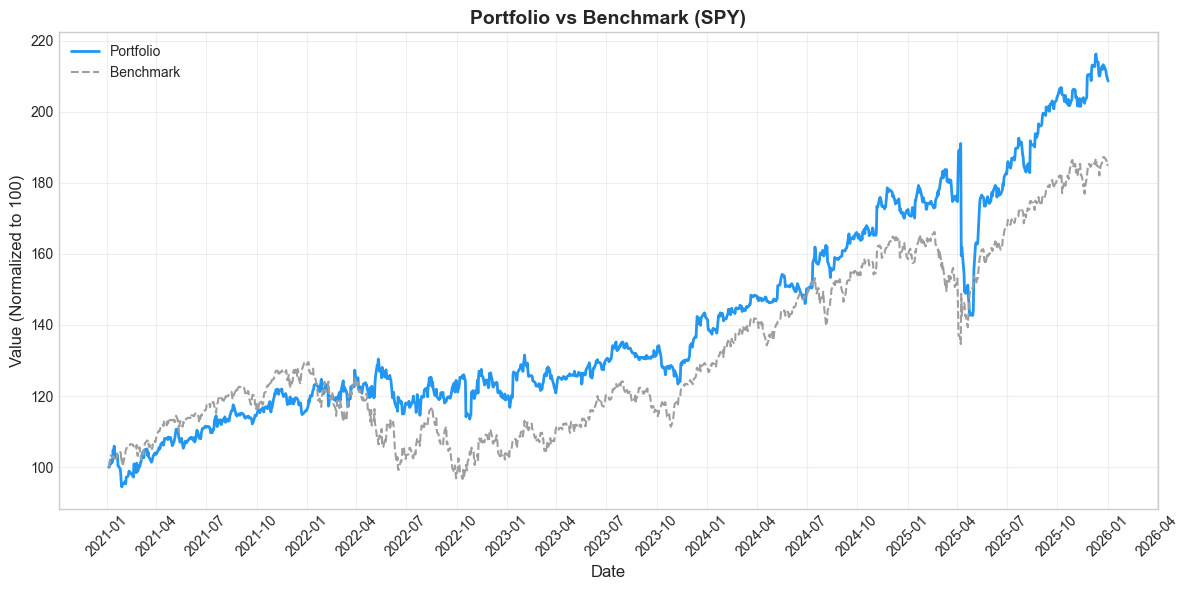

In [10]:
# Create benchmark equity curve for comparison
benchmark_equity = None
if benchmark_data is not None and len(benchmark_data) > 0 and len(result.equity_curve) > 0:
    # Align benchmark to backtest period
    start = result.equity_curve.index[0]
    end = result.equity_curve.index[-1]
    bench = benchmark_data.loc[start:end, "close"]
    if len(bench) > 0:
        # Normalize to same starting value
        benchmark_equity = bench / bench.iloc[0] * result.equity_curve.iloc[0]

# Plot equity curve
fig = plot_equity_curve(
    result.equity_curve,
    benchmark_curve=benchmark_equity,
    title="Portfolio vs Benchmark (SPY)",
)
plt.show()

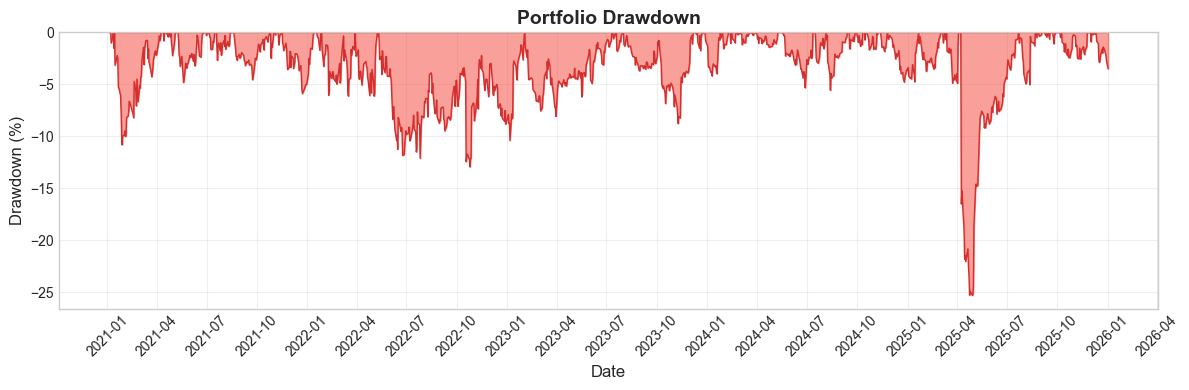

In [11]:
# Plot drawdown
fig = plot_drawdown(result.equity_curve, title="Portfolio Drawdown")
plt.show()

/Users/bradycooke/trend-follower/src/reporting/charts.py:519: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


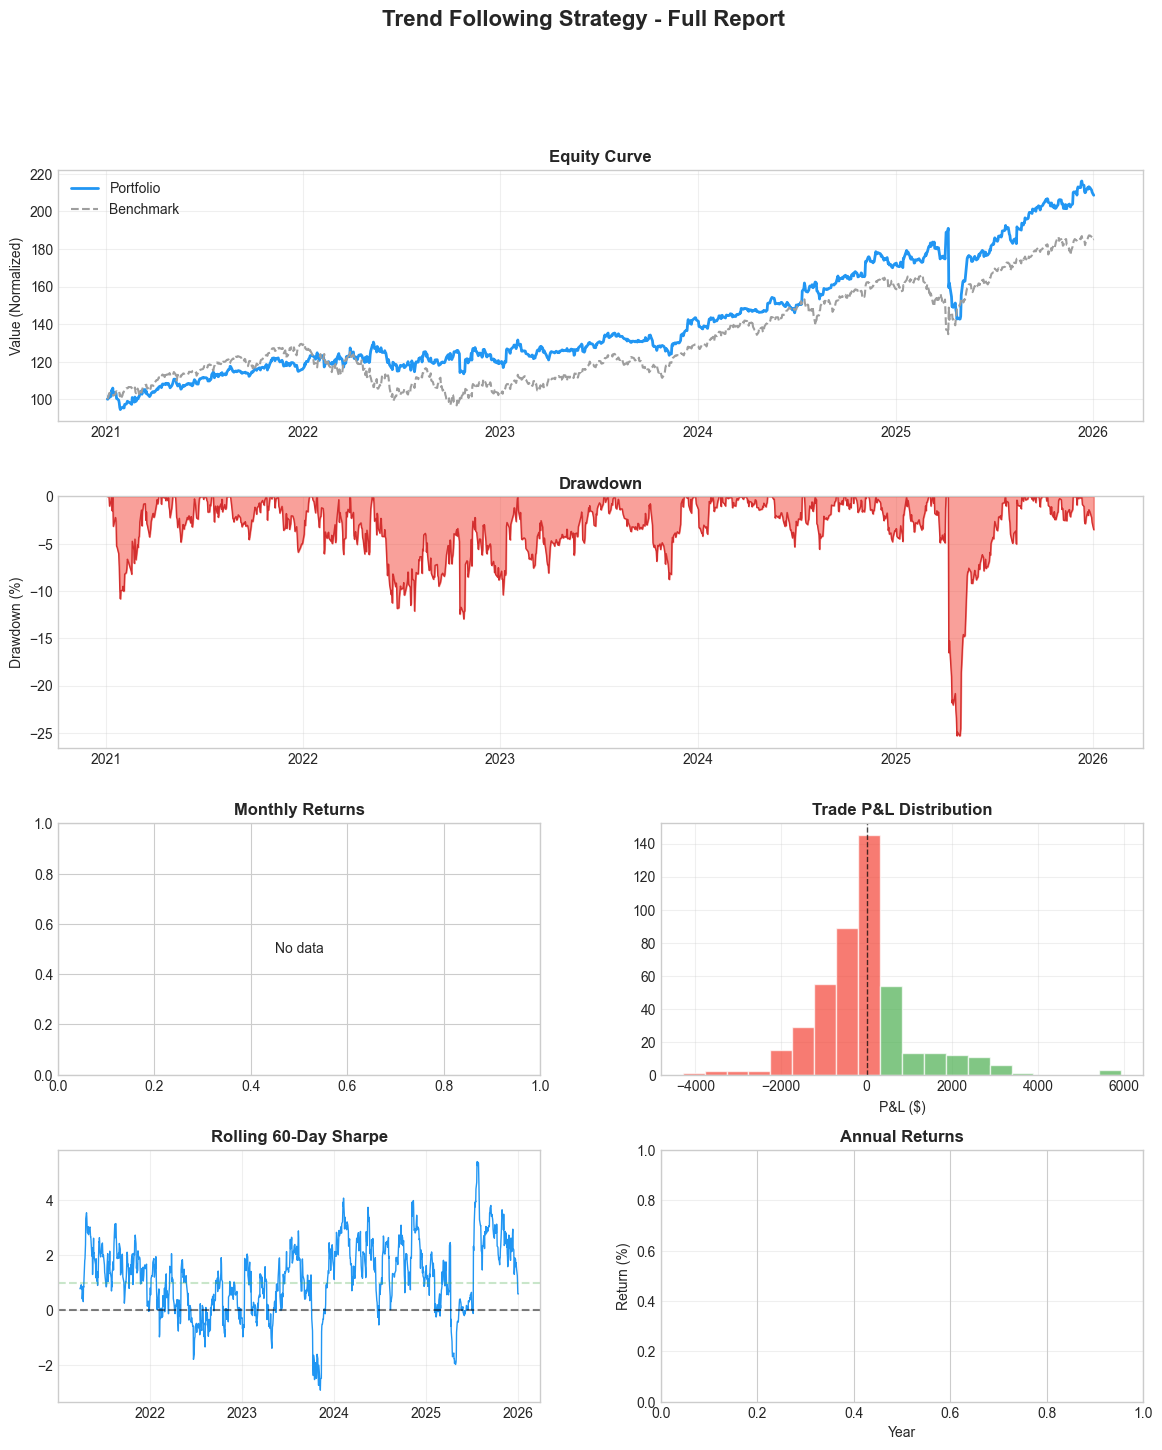

In [12]:
# Create comprehensive report
fig = create_backtest_report(
    metrics=result.metrics,
    equity_curve=result.equity_curve,
    trades=result.trades,
    benchmark_curve=benchmark_equity,
    title="Trend Following Strategy - Full Report",
)
plt.show()

## 6. Trade Analysis

In [13]:
# Analyze trades by symbol
import pandas as pd

if result.trades:
    trade_df = pd.DataFrame([
        {
            "symbol": t.symbol,
            "side": t.side.name,
            "pnl": t.pnl,
            "pnl_pct": t.pnl_pct,
            "holding_days": t.holding_days,
            "exit_reason": t.exit_reason,
        }
        for t in result.trades
    ])
    
    # Summary by symbol
    symbol_summary = trade_df.groupby("symbol").agg({
        "pnl": ["count", "sum", "mean"],
        "holding_days": "mean",
    }).round(2)
    symbol_summary.columns = ["trades", "total_pnl", "avg_pnl", "avg_days"]
    symbol_summary = symbol_summary.sort_values("total_pnl", ascending=False)
    
    print("Top 10 Symbols by P&L:")
    print(symbol_summary.head(10))
    print("\nBottom 10 Symbols by P&L:")
    print(symbol_summary.tail(10))
else:
    print("No trades to analyze.")

Top 10 Symbols by P&L:
        trades  total_pnl  avg_pnl  avg_days
symbol                                      
XTL         16    9849.81   615.61     32.56
XBI         13    7656.49   588.96     34.77
XHB         15    5130.47   342.03     38.80
XLK         15    4962.92   330.86     34.27
XLI         10    4372.26   437.23     40.50
XLC         16    4148.10   259.26     40.19
XME         12    3354.11   279.51     34.33
XLV         17    1932.80   113.69     35.35
XPH         14    1786.92   127.64     31.00
XRT          7    1350.75   192.96     38.43

Bottom 10 Symbols by P&L:
        trades  total_pnl  avg_pnl  avg_days
symbol                                      
EEM         18   -3267.12  -181.51     23.83
GNR         19   -3431.62  -180.61     21.05
XLB         14   -3941.51  -281.54     28.64
XSD         17   -5041.02  -296.53     26.71
XLE         16   -5072.68  -317.04     28.50
XES         18   -5317.86  -295.44     26.61
KBE         11   -5563.96  -505.81     30.55
XLF  

In [14]:
# Exit reason analysis
if result.trades:
    exit_summary = trade_df.groupby("exit_reason").agg({
        "pnl": ["count", "sum", "mean"],
    }).round(2)
    exit_summary.columns = ["count", "total_pnl", "avg_pnl"]
    print("Trades by Exit Reason:")
    print(exit_summary)

Trades by Exit Reason:
             count  total_pnl  avg_pnl
exit_reason                           
stop           453  -25362.88   -55.99


In [15]:
# Long vs Short performance
if result.trades:
    side_summary = trade_df.groupby("side").agg({
        "pnl": ["count", "sum", "mean"],
        "pnl_pct": "mean",
    }).round(2)
    side_summary.columns = ["count", "total_pnl", "avg_pnl", "avg_pct"]
    print("Long vs Short Performance:")
    print(side_summary)

Long vs Short Performance:
       count  total_pnl  avg_pnl  avg_pct
side                                     
LONG     258   41147.59   159.49      1.0
SHORT    195  -66510.47  -341.08     -1.8


## 7. Save Results

In [16]:
# Save equity curve to CSV
output_dir = project_root / "output"
output_dir.mkdir(exist_ok=True)

if len(result.equity_curve) > 0:
    result.equity_curve.to_csv(output_dir / "equity_curve.csv")
    print(f"Equity curve saved to {output_dir / 'equity_curve.csv'}")

    # Save trades to CSV
    if result.trades:
        trade_df.to_csv(output_dir / "trades.csv", index=False)
        print(f"Trades saved to {output_dir / 'trades.csv'}")
else:
    print("No results to save.")

Equity curve saved to /Users/bradycooke/trend-follower/output/equity_curve.csv
Trades saved to /Users/bradycooke/trend-follower/output/trades.csv


In [17]:
# Save report figure
if len(result.equity_curve) > 0:
    fig = create_backtest_report(
        metrics=result.metrics,
        equity_curve=result.equity_curve,
        trades=result.trades,
        benchmark_curve=benchmark_equity,
        title="Trend Following Strategy Report",
        save_path=output_dir / "backtest_report.png",
    )
    plt.close(fig)
    print(f"Report saved to {output_dir / 'backtest_report.png'}")

Report saved to /Users/bradycooke/trend-follower/output/backtest_report.png


/Users/bradycooke/trend-follower/src/reporting/charts.py:519: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


## 8. Next Steps

1. **Parameter Optimization**: Try different Keltner periods, ATR multipliers, and stop levels
2. **Walk-Forward Testing**: Use rolling windows to validate out-of-sample performance
3. **Live Trading**: Connect to Interactive Brokers using the execution layer
4. **Risk Analysis**: Examine correlation with benchmark during different market regimes

In [18]:
# Clean up
db.close()
print("Database connection closed.")

Database connection closed.
